In [61]:
import pandas as pd

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import decomposition, preprocessing

import matplotlib.pyplot as plt
import numpy as np

from functions import *

#import plotly.express as px
#import plotly.graph_objs as go
#import plotly.figure_factory as ff
#import seaborn as sns
#from mpl_toolkits.mplot3d import axes3d
#from mpl_toolkits.mplot3d import proj3d
#from matplotlib.patches import FancyArrowPatch

import seaborn as sns

In [19]:
# read data from csv
df_yt = pd.read_csv("youtube_videos.tsv", sep="\t")
df_mes = pd.read_csv("transcoding_mesurment.tsv", sep="\t")

# Add a pixel column as height and width are obviously heavily correlated
df_mes['o_pixels'] = df_mes['o_height'] * df_mes['o_width']

# Remove useless columns for linear regression
del df_mes['id']
del df_mes['codec']
del df_mes['o_codec']

df_mes_copy = df_mes.copy()
del df_mes_copy['o_width']
del df_mes_copy['o_height']


# model feature are composed of all colomns except the first one (the video id) and the last two ones (prediction values umeme and utime)
features = df_mes.columns[1:-2]

df_mes.sample(15)

,duration,width,height,bitrate,framerate,i,p,b,frames,i_size,p_size,b_size,size,o_bitrate,o_framerate,o_width,o_height,umem,utime,o_pixels
25788,127.221664,1920,1080,3080852,23.000000,70,2980,0,3050,3818903,45174992,0,48993895,3000000,25.00,176,144,217544,7.656,25344
699,130.356670,176,144,54590,12.000000,27,1537,0,1564,64483,825054,0,889537,242000,15.00,640,480,135804,9.277,307200
23842,448.575000,1280,720,2052426,30.002232,92,13349,0,13441,9132637,105950761,0,115083398,539000,25.00,1280,720,217080,33.954,921600
8060,476.957000,1280,720,1387100,30.052520,105,14200,0,14305,3487520,79210885,0,82698405,242000,25.00,480,360,165700,3.396,172800
47640,385.052000,1280,720,441862,23.979221,77,9155,0,9232,16244376,5023129,0,21267505,5000000,12.00,176,144,219480,1.280,25344
46790,292.092000,480,360,480125,29.000000,156,8599,0,8755,2375028,15155062,0,17530090,3000000,25.00,480,360,219480,1.724,172800
38745,37.011665,1280,720,2759449,29.000000,21,1088,0,1109,1899633,10866846,0,12766479,539000,24.00,640,480,219480,6.392,307200
38207,80.536000,480,360,690041,29.000000,43,2374,0,2417,618732,6327913,0,6946645,5000000,24.00,1920,1080,219480,69.352,2073600
32284,326.588320,1920,1080,5999648,23.000000,174,7656,0,7830,16603953,228322925,0,244926878,3000000,12.00,1280,720,218932,29.334,921600
51484,167.391660,1280,720,2207484,24.000000,86,3931,0,4017,4369420,41819887,0,46189307,109000,12.00,1280,720,219656,12.517,921600


In [3]:
# Check null values : there are none :p)
df_mes.isnull().sum().loc[features]

width          0
height         0
bitrate        0
framerate      0
i              0
p              0
b              0
frames         0
i_size         0
p_size         0
b_size         0
size           0
o_bitrate      0
o_framerate    0
o_width        0
o_height       0
dtype: int64

<AxesSubplot:>

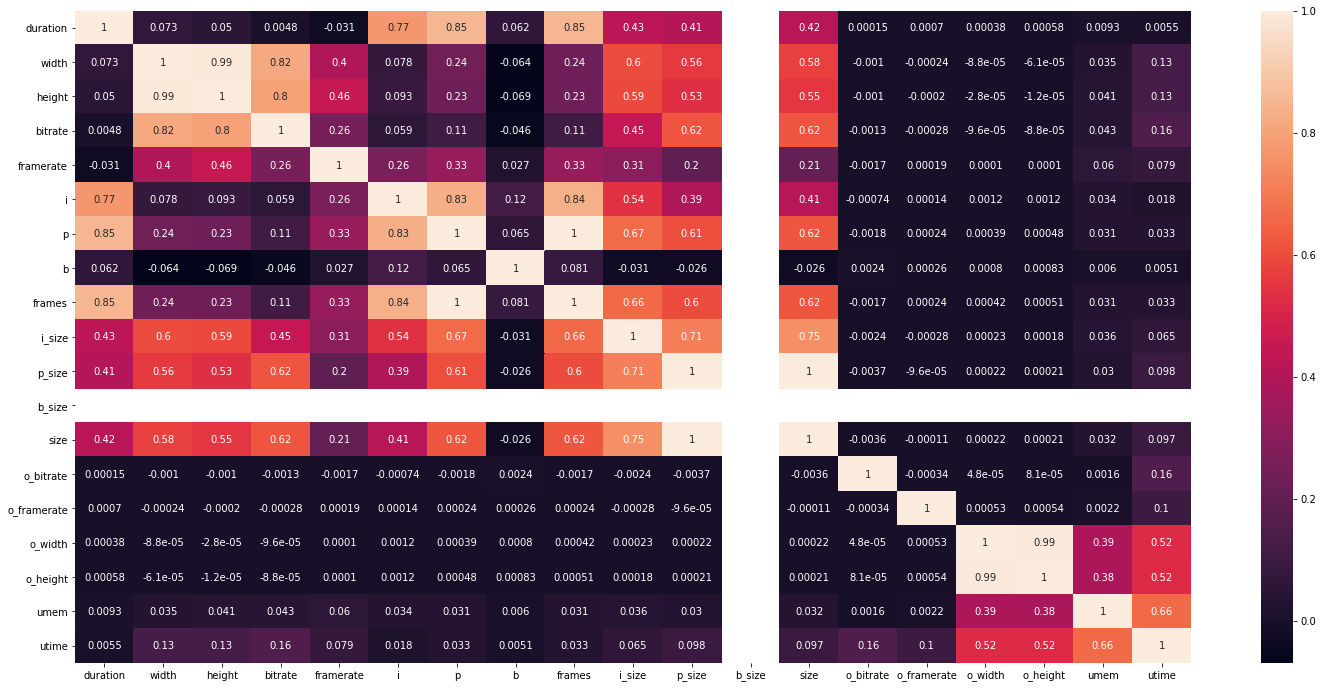

In [4]:
# Correlation matrix

correlation_mat = df_mes.corr()
plt.figure(figsize=(25,12))
sns.heatmap(correlation_mat, annot = True)


The explained variance of all PCA components are :
[5.91201587e+00 2.76989536e+00 2.05715383e+00 1.07871809e+00
 1.01851456e+00 1.00033020e+00 9.49172105e-01 6.02296504e-01
 5.56102926e-01 3.64934390e-01 2.74206212e-01 2.63383821e-01
 9.42892546e-02 5.31641506e-02 6.06948927e-03 3.79835143e-07
 2.74143345e-30 4.42420335e-35]


The explained corrected variance of all PCA components are :
[5.91192992e+00 2.76985509e+00 2.05712393e+00 1.07870241e+00
 1.01849975e+00 1.00031566e+00 9.49158305e-01 6.02287747e-01
 5.56094842e-01 3.64929085e-01 2.74202225e-01 2.63379992e-01
 9.42878838e-02 5.31633777e-02 6.06940103e-03 3.79829621e-07
 2.74139360e-30 4.42413903e-35]


The proportions of explained variance are :
[3.47760584e-01 1.62932652e-01 1.21007290e-01 6.34530829e-02
 5.99117502e-02 5.88420976e-02 5.58328415e-02 3.54286910e-02
 3.27114613e-02 2.14664168e-02 1.61295427e-02 1.54929407e-02
 5.54634611e-03 3.12725751e-03 3.57023590e-04 2.23429189e-08
 1.61258447e-31 2.60243472e-36]



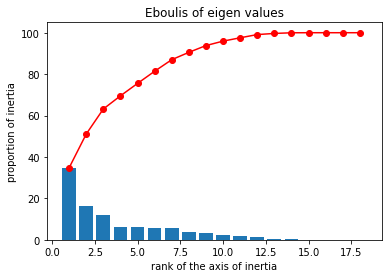

       Eigen.Val  Threshold
0   5.911930e+00   3.495108
1   2.769855e+00   2.495108
2   2.057124e+00   1.995108
3   1.078702e+00   1.661775
4   1.018500e+00   1.411775
5   1.000316e+00   1.211775
6   9.491583e-01   1.045108
7   6.022877e-01   0.902251
8   5.560948e-01   0.777251
9   3.649291e-01   0.666140
10  2.742022e-01   0.566140
11  2.633800e-01   0.475231
12  9.428788e-02   0.391897
13  5.316338e-02   0.314974
14  6.069401e-03   0.243546
15  3.798296e-07   0.176879
16  2.741394e-30   0.114379
17  4.424139e-35   0.055556


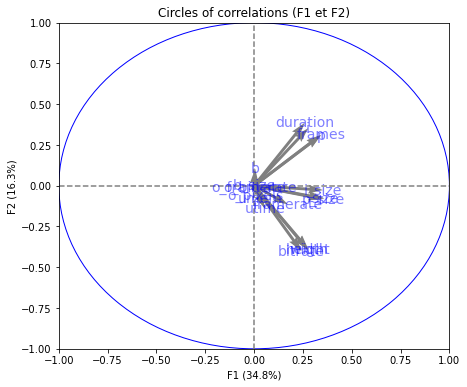

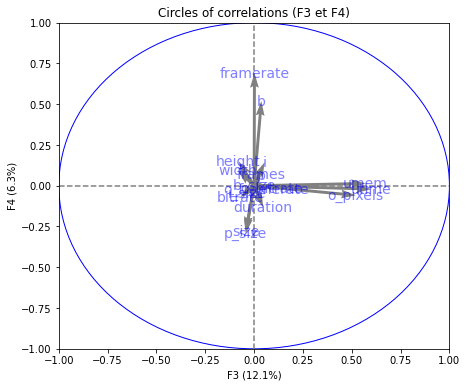

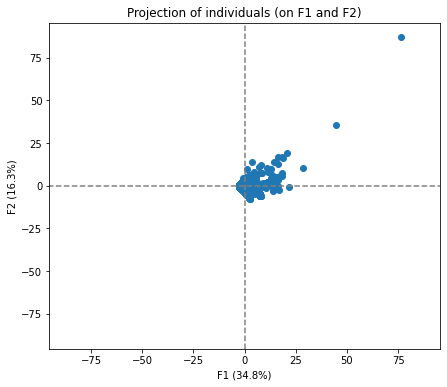

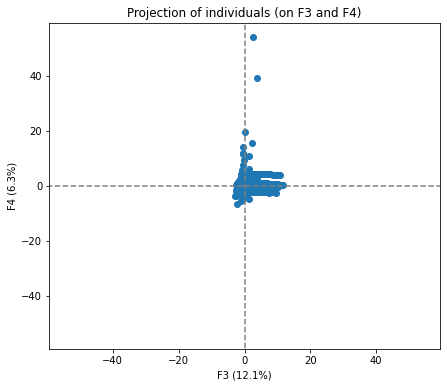


The square cosine of the variables for the first two axes :
             id    COS2_1        COS2_2
0      duration  0.395383  4.111787e-01
1         width  0.455992  4.239182e-01
2        height  0.445675  4.258898e-01
3       bitrate  0.346663  4.453914e-01
4     framerate  0.176250  3.636411e-02
5             i  0.451174  3.437954e-01
6             p  0.693268  2.649776e-01
7             b  0.000185  2.981747e-02
8        frames  0.691562  2.693114e-01
9        i_size  0.734082  1.961016e-03
10       p_size  0.733168  1.833737e-02
11       b_size  0.000000  1.212936e-46
12         size  0.764855  1.713216e-02
13    o_bitrate  0.000002  3.789293e-04
14  o_framerate  0.000008  1.713672e-04
15         umem  0.005500  1.763239e-02
16        utime  0.017725  5.385708e-02
17     o_pixels  0.000437  9.740767e-03

The contributions of the variables for the first two axes :
             id         CTR_1         CTR_2
0      duration  6.687890e-02  1.484477e-01
1         width  7.713076e-02 

In [65]:
# Principal Components Analysis

data_pca = df_mes_copy
data_pca = data_pca.fillna(data_pca.mean())
X = data_pca.values 
names = data_pca.index 
features = data_pca.columns
n = data_pca.shape[0]
p = data_pca.shape[1]


# Scale the data
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# calculate the main components
pca = decomposition.PCA()
pca.fit(X_scaled)


# Explained variance
print("\nThe explained variance of all PCA components are :\n"+str(pca.explained_variance_)+"\n")

# Explained corrected variance
eigval = (n-1)/n*pca.explained_variance_
print("\nThe explained corrected variance of all PCA components are :\n"+str(eigval)+"\n")

# Proportions of explained variance
print ("\nThe proportions of explained variance are :\n"+str(pca.explained_variance_ratio_)+"\n")

# Eboulis of eigen values 
display_scree_plot(pca)


# Thresholds for testing broken sticks
bs = 1/np.arange(p,0,-1)
bs = np.cumsum(bs)
bs = bs[::-1]

# Test of broken sticks
print(pd.DataFrame({'Eigen.Val':eigval,'Threshold':bs}))

# we choose the firts four components
n_comp = 4


# Circles of correlations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features))

 
# Projection of individuals
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)])

# Correlation of the variables with the axes
corvar = np.zeros((p,p))
sqrt_eigval = np.sqrt(eigval)

for k in range(p):
  corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]

# Square cosine of the variables
cos2var = corvar**2

print("\nThe square cosine of the variables for the first two axes :\n"+str(pd.DataFrame({'id':data_pca.columns,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1]})))

# Contributions
ctrvar = cos2var
for k in range(p):
  ctrvar[:,k] = ctrvar[:,k]/eigval[k]# only the first two axes are displayed
  
print("\nThe contributions of the variables for the first two axes :\n"+str(pd.DataFrame({'id':data_pca.columns,'CTR_1':ctrvar[:,0],'CTR_2':ctrvar[:,1]})))

In [20]:
# Split train and test datasets
Y = df_mes[["utime"]]
x_train, x_test, y_train, y_test = train_test_split(df_mes, Y, test_size=0.2)

# test
Y_tmp = df_mes_copy[["utime"]]
x_train_tmp, x_test_tmp, y_train_tmp, y_test_tmp = train_test_split(df_mes_copy, Y_tmp, test_size=0.2)

In [6]:
df_yt

,id,duration,bitrate,bitrate(video),height,width,frame rate,frame rate(est.),codec,category,url
0,uDNj-_5ty48,267,373,274,568,320,29.97,0.00,h264,Music,http://r2---sn-ovgq0oxu-5goe.c.youtube.com/vid...
1,uDNj-_5ty48,267,512,396,480,270,29.97,29.97,h264,Music,http://r2---sn-ovgq0oxu-5goe.c.youtube.com/vid...
2,uDNj-_5ty48,267,324,263,400,226,29.97,29.97,flv1,Music,http://r2---sn-ovgq0oxu-5goe.c.youtube.com/vid...
3,uDNj-_5ty48,267,85,55,176,144,12.00,12.00,mpeg4,Music,http://r2---sn-ovgq0oxu-5goe.c.youtube.com/vid...
4,WCgt-AactyY,31,1261,1183,640,480,24.00,0.00,h264,People & Blogs,http://r1---sn-ovgq0oxu-5goe.c.youtube.com/vid...
...,...,...,...,...,...,...,...,...,...,...,...
168281,ehHw-P9S4lU,68,816,560,480,360,29.97,29.97,vp8,Music,http://r1---sn-ovgq0oxu-5goe.c.youtube.com/vid...
168282,ehHw-P9S4lU,68,340,273,320,240,29.97,29.97,flv1,Music,http://r1---sn-ovgq0oxu-5goe.c.youtube.com/vid...
168283,ehHw-P9S4lU,68,81,55,176,144,12.00,12.00,mpeg4,Music,http://r1---sn-ovgq0oxu-5goe.c.youtube.com/vid...
168284,MzjT-56gXno,285,1290,1181,854,480,29.97,0.00,h264,Sports,http://r4---sn-ovgq0oxu-5goe.c.youtube.com/vid...


In [7]:
df_mes

,duration,width,height,bitrate,framerate,i,p,b,frames,i_size,p_size,b_size,size,o_bitrate,o_framerate,o_width,o_height,umem,utime
0,130.35667,176,144,54590,12.000000,27,1537,0,1564,64483,825054,0,889537,56000,12.00,176,144,22508,0.612
1,130.35667,176,144,54590,12.000000,27,1537,0,1564,64483,825054,0,889537,56000,12.00,320,240,25164,0.980
2,130.35667,176,144,54590,12.000000,27,1537,0,1564,64483,825054,0,889537,56000,12.00,480,360,29228,1.216
3,130.35667,176,144,54590,12.000000,27,1537,0,1564,64483,825054,0,889537,56000,12.00,640,480,34316,1.692
4,130.35667,176,144,54590,12.000000,27,1537,0,1564,64483,825054,0,889537,56000,12.00,1280,720,58528,3.456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68779,972.27100,480,360,278822,29.000000,560,28580,0,29140,7324628,26561730,0,33886358,242000,24.00,640,480,88692,1.552
68780,129.88100,640,480,639331,30.162790,36,3855,0,3891,875784,9503846,0,10379630,539000,29.97,1920,1080,107524,18.557
68781,249.68000,320,240,359345,25.068274,129,6113,0,6242,1758664,9456514,0,11215178,539000,12.00,176,144,88708,0.752
68782,183.62334,1280,720,2847539,29.000000,98,5405,0,5503,5246294,60113035,0,65359329,539000,12.00,320,240,88724,5.444


In [8]:
df_yt.head()

,id,duration,bitrate,bitrate(video),height,width,frame rate,frame rate(est.),codec,category,url
0,uDNj-_5ty48,267,373,274,568,320,29.97,0.00,h264,Music,http://r2---sn-ovgq0oxu-5goe.c.youtube.com/vid...
1,uDNj-_5ty48,267,512,396,480,270,29.97,29.97,h264,Music,http://r2---sn-ovgq0oxu-5goe.c.youtube.com/vid...
2,uDNj-_5ty48,267,324,263,400,226,29.97,29.97,flv1,Music,http://r2---sn-ovgq0oxu-5goe.c.youtube.com/vid...
3,uDNj-_5ty48,267,85,55,176,144,12.00,12.00,mpeg4,Music,http://r2---sn-ovgq0oxu-5goe.c.youtube.com/vid...
4,WCgt-AactyY,31,1261,1183,640,480,24.00,0.00,h264,People & Blogs,http://r1---sn-ovgq0oxu-5goe.c.youtube.com/vid...


In [9]:
df_mes.head()

,duration,width,height,bitrate,framerate,i,p,b,frames,i_size,p_size,b_size,size,o_bitrate,o_framerate,o_width,o_height,umem,utime
0,130.35667,176,144,54590,12.0,27,1537,0,1564,64483,825054,0,889537,56000,12.0,176,144,22508,0.612
1,130.35667,176,144,54590,12.0,27,1537,0,1564,64483,825054,0,889537,56000,12.0,320,240,25164,0.980
2,130.35667,176,144,54590,12.0,27,1537,0,1564,64483,825054,0,889537,56000,12.0,480,360,29228,1.216
3,130.35667,176,144,54590,12.0,27,1537,0,1564,64483,825054,0,889537,56000,12.0,640,480,34316,1.692
4,130.35667,176,144,54590,12.0,27,1537,0,1564,64483,825054,0,889537,56000,12.0,1280,720,58528,3.456


In [28]:
# Linear regression
lr = LinearRegression()
lr.fit(x_train, y_train)

lr_tmp = LinearRegression()
lr_tmp.fit(x_train_tmp, y_train_tmp)

3.322493256867855e-27

In [27]:
# Accuracy

y_pred = lr.predict(x_test)
mean_squared_error(y_test, y_pred)

6.342932319752978e-27

In [26]:
# Accuracy 1

y_pred_tmp = lr_tmp.predict(x_test_tmp)
mean_squared_error(y_test_tmp, y_pred_tmp)

3.322493256867855e-27

In [56]:
# Predict
video = df_mes.loc[4].tolist()
lr.predict([video]).item(0)

3.455999999999882

In [34]:
# Linear regression

regressor = RandomForestRegressor(n_estimators=len(features), random_state=0)
regressor.fit(x_train, y_train)
y_pred_rf = regressor.predict(x_test)
mean_squared_error(y_test, y_pred_rf)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.0253670226320768

In [39]:
# Grid validation search, to find the best parameters with random forest model

param_grid = {
    'n_estimators': [5, 10, 15, 20],
    'max_depth': [2, 5, 7, 9]
}
grid_clf = GridSearchCV(regressor, param_grid, cv=10)
grid_clf.fit(x_train, y_train)

/opt/venv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/venv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/venv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/venv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d a

GridSearchCV(cv=10,
             estimator=RandomForestRegressor(n_estimators=17, random_state=0),
             param_grid={'max_depth': [2, 5, 7, 9],
                         'n_estimators': [5, 10, 15, 20]})

In [40]:
grid_clf. best_estimator_

RandomForestRegressor(max_depth=9, n_estimators=5, random_state=0)

In [41]:
grid_clf. best_params_

{'max_depth': 9, 'n_estimators': 5}

In [42]:
grid_clf.cv_results_

{'mean_fit_time': array([0.23394654, 0.55133228, 1.08550038, 1.11723976, 0.82493196,
        1.18769238, 1.80959599, 2.4808742 , 0.73752589, 1.83221977,
        2.35110755, 3.35220101, 1.39842129, 2.57117345, 3.2441745 ,
        4.19723198]),
 'std_fit_time': array([0.02929002, 0.10816958, 0.18615856, 0.29474692, 0.18123336,
        0.1285169 , 0.43229821, 0.5408308 , 0.07977138, 0.45648268,
        0.18812297, 0.53067536, 0.27955934, 0.47544238, 0.64863376,
        0.65456182]),
 'mean_score_time': array([0.00595939, 0.00884352, 0.01249056, 0.00959713, 0.01002684,
        0.00943289, 0.01051495, 0.01252227, 0.00701792, 0.01178823,
        0.01252656, 0.01471822, 0.01114261, 0.01504221, 0.01499753,
        0.01977518]),
 'std_score_time': array([0.00112662, 0.00294116, 0.00227856, 0.00320232, 0.00234408,
        0.00187952, 0.00308116, 0.00320881, 0.00087769, 0.00262784,
        0.00164473, 0.0037203 , 0.00334038, 0.00417283, 0.00337653,
        0.00484249]),
 'param_max_depth': masked

In [43]:
# Linear regression with best params

# As expected, aren't very accurate in regression (they are better for classification)

regressor = RandomForestRegressor(n_estimators=5, random_state=0, max_depth=9)
regressor.fit(x_train, y_train)
y_pred_rf = regressor.predict(x_test)
mean_squared_error(y_test, y_pred_rf)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


0.0269498141409094

In [55]:
video = df_mes.loc[4].tolist()
pred = regressor.predict([video])
pred.item(0)

3.447268917903569